<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parse-the-data-and-set-parameters" data-toc-modified-id="Parse-the-data-and-set-parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parse the data and set parameters</a></span><ul class="toc-item"><li><span><a href="#Choose-the-data-with-SAS-or-TG-as-the-beginning-of-the-line-Region-of-Interest" data-toc-modified-id="Choose-the-data-with-SAS-or-TG-as-the-beginning-of-the-line-Region-of-Interest-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Choose the data with SAS or TG as the beginning of the line Region of Interest</a></span></li><li><span><a href="#Parse-the-raw-data" data-toc-modified-id="Parse-the-raw-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Parse the raw data</a></span></li></ul></li><li><span><a href="#Compare-a-model-prediction-with-data" data-toc-modified-id="Compare-a-model-prediction-with-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compare a model prediction with data</a></span></li><li><span><a href="#Find-error-minimizing-diffusion-coefficient-for-each-dataset" data-toc-modified-id="Find-error-minimizing-diffusion-coefficient-for-each-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Find error-minimizing diffusion coefficient for each dataset</a></span></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot results</a></span></li></ul></div>

In [114]:
import TGdiffusion_convolution_fitting as cs
import parsingTG as ptg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import pickle
from os import listdir
from glob import glob
from itertools import product
from tqdm import tqdm

import imp
imp.reload(cs)
imp.reload(ptg)

<module 'parsingTG' from '/Users/lgn148/Library/CloudStorage/GoogleDrive-peterarbork@gmail.com/My Drive/PhD/small tasks/Martin TG Diffusion/TG-Diffusion/src/parsingTG.py'>

# Parse the data and set parameters

- The $\lambda$ = `lam` parameter controls the regularization term in the loss function.
- The `subsampleskipsteps` parameter controls how downsampled the data is in the time-axis.
- The `maxiter` parameter is deprecated (not used, but the optimizer function can be easily modified to use it, see the python module TGdiffusion_convolution_fitting.py).

In [115]:
lam = 0.01
subsampleskipsteps = 12
maxiter = 50

## Choose the data with SAS or TG as the beginning of the line Region of Interest

In [116]:
rawdatafolder = "../data/linerois_all/"
parseddatafolder = "../data/parsed/SAS_source/"
resultsfolder = "../data/results/SAS_source/"

In [129]:
rawdatafolder = "../data/linerois_all/"
parseddatafolder = "../data/parsed/TG_source/"
resultsfolder = "../data/results/TG_source/"

In [130]:
parsedfolders = glob(parseddatafolder + '*', recursive=True)
parsedfolders

['../data/parsed/TG_source/a1_left',
 '../data/parsed/TG_source/a3_left',
 '../data/parsed/TG_source/a1_right',
 '../data/parsed/TG_source/a2_left',
 '../data/parsed/TG_source/a3_right',
 '../data/parsed/TG_source/a4_right',
 '../data/parsed/TG_source/a4_left',
 '../data/parsed/TG_source/a2_right']

## Parse the raw data

This code does not need to be run every you do the analyses! Parsing once will suffice, so you can skip this cell (until you wish to change some of the parameters in it of course).

Parse raw data to 2D conc. matrices, a source vector, a time vector and a distance vector, and put these in their own folder

In [131]:
pixelsize_mm = 0.065,
frameduration_h = (45.0 / 60) / 60.0

parsing a1_left... 


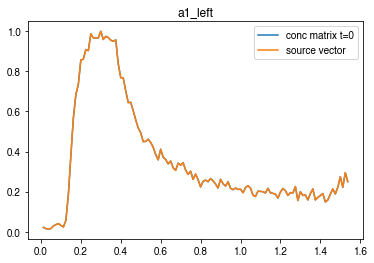

parsing a1_right... 


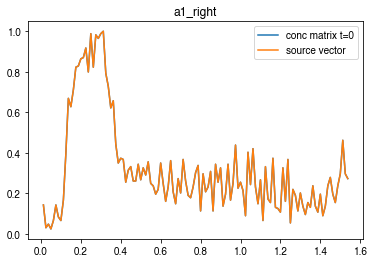

parsing a2_left... 


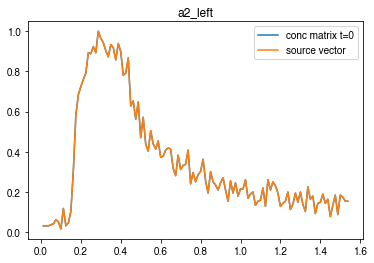

parsing a2_right... 


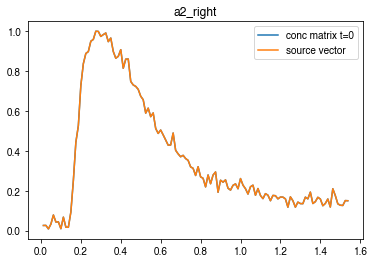

parsing a3_left... 


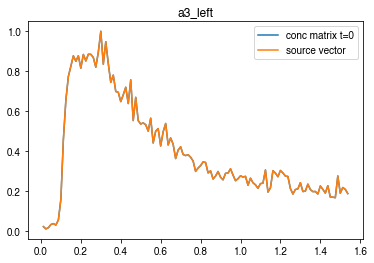

parsing a3_right... 


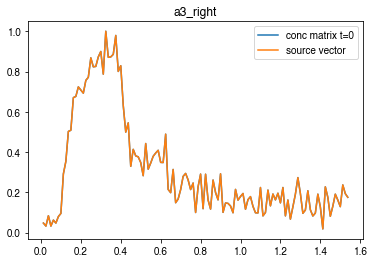

parsing a4_left... 


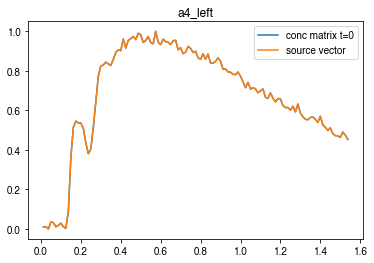

parsing a4_right... 


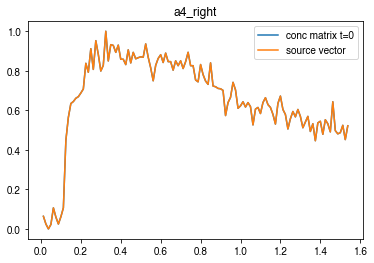

In [132]:
animalsidecombos = ['_'.join(p) for p in product(["a1", "a2", "a3", "a4"], ["left", "right"])]

for animalsidecombo in animalsidecombos:
    print(f"parsing {animalsidecombo}... ")
    (conc_matrix, source_vector, time_vector,
     distance_vector) = ptg.parseanimalside(
        rawdatafolder,
        parseddatafolder,
        animalsidecombo,
        pixelsize_mm=pixelsize_mm,
        frameduration_h=frameduration_h,
        num_pixels_to_average_source_over=1,
    )

# Compare a model prediction with data

In [133]:
folder = parsedfolders[2]
print(f'Using folder {folder}')

source_vector = np.load(folder + "/source_vector.npy")
conc_matrix = np.load(folder + "/concmatrix.npy")
time_vector = np.load(folder + "/time_vector.npy")
distance_vector = np.load(folder + "/distance_vector.npy")

Using folder ../data/parsed/TG_source/a1_right


In [134]:
predfunc = cs.make_prediction_func(
    source_vector,
    conc_matrix,
    time_vector,
    distance_vector,
)

In [135]:
Dguess = 0.267199
prediction = predfunc(Dguess)

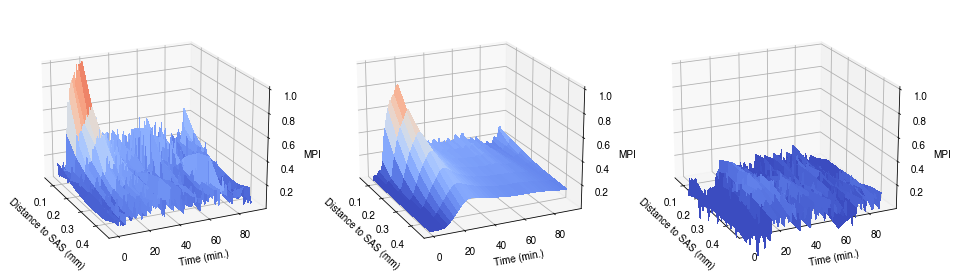

In [136]:
cs.plot_prediction_data_error(
    distance_vector,
    60 * time_vector,
    prediction,
    conc_matrix,
);

# Find error-minimizing diffusion coefficient for each dataset

In [137]:
imp.reload(ptg)
imp.reload(cs)

<module 'TGdiffusion_convolution_fitting' from '/Users/lgn148/Library/CloudStorage/GoogleDrive-peterarbork@gmail.com/My Drive/PhD/small tasks/Martin TG Diffusion/TG-Diffusion/src/TGdiffusion_convolution_fitting.py'>

In [138]:
resultsdict = dict()
minresults = []


for folder in tqdm(parsedfolders):
    print("Finding best D for folder", folder, ". ", end="")
    
    try:
        D, RMS, identifier, minresult = cs.find_RMS_minimizing_D_for_data_in_folder(
            folder,
            lam,
            subsampleskipsteps,
            maxiter
        )

        resultsdict[identifier] = (identifier, D, RMS)
        minresults.append(minresult)
        print("success: ", minresult.success)
        
    except ValueError as ve:
        print(ve)
        raise ve

resultsdf = pd.DataFrame.from_dict(resultsdict, orient='index', columns=["ID", "D", "error"])
resultsdf.to_csv(resultsfolder + f'results_with_lam_{lam}.csv', index=False)

  0%|          | 0/8 [00:00<?, ?it/s]

Finding best D for folder ../data/parsed/TG_source/a1_left . 

/Users/lgn148/Library/CloudStorage/GoogleDrive-peterarbork@gmail.com/My Drive/PhD/small tasks/Martin TG Diffusion/TG-Diffusion/src/TGdiffusion_convolution_fitting.py:36: RuntimeWarning: divide by zero encountered in true_divide
  denom = np.sqrt(4 * np.pi * D * t**3)
/Users/lgn148/Library/CloudStorage/GoogleDrive-peterarbork@gmail.com/My Drive/PhD/small tasks/Martin TG Diffusion/TG-Diffusion/src/TGdiffusion_convolution_fitting.py:39: RuntimeWarning: invalid value encountered in true_divide
  
 12%|█▎        | 1/8 [00:29<03:26, 29.55s/it]

success:  True
Finding best D for folder ../data/parsed/TG_source/a3_left . 

 25%|██▌       | 2/8 [00:59<02:57, 29.55s/it]

success:  True
Finding best D for folder ../data/parsed/TG_source/a1_right . 

 38%|███▊      | 3/8 [01:29<02:30, 30.11s/it]

success:  True
Finding best D for folder ../data/parsed/TG_source/a2_left . 

 50%|█████     | 4/8 [01:59<02:00, 30.05s/it]

success:  True
Finding best D for folder ../data/parsed/TG_source/a3_right . 

 62%|██████▎   | 5/8 [02:29<01:29, 29.91s/it]

success:  True
Finding best D for folder ../data/parsed/TG_source/a4_right . 

 75%|███████▌  | 6/8 [02:56<00:57, 28.78s/it]

success:  True
Finding best D for folder ../data/parsed/TG_source/a4_left . 

 88%|████████▊ | 7/8 [03:23<00:28, 28.36s/it]

success:  True
Finding best D for folder ../data/parsed/TG_source/a2_right . 

100%|██████████| 8/8 [03:53<00:00, 29.20s/it]

success:  True


# Plot results

In [139]:
resultsdf = pd.read_csv(resultsfolder + f'results_with_lam_{lam}.csv')
resultsdf

,ID,D,error
0,a1_left,0.077560,0.724708
1,a3_left,0.042516,0.864359
2,a1_right,0.230212,0.500792
3,a2_left,0.219611,0.507721
4,a3_right,0.157416,0.516955
5,a4_right,0.115536,0.425244
6,a4_left,0.100241,0.417955
7,a2_right,0.064693,0.834062


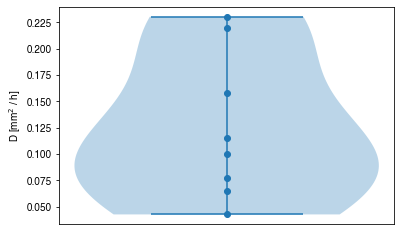

In [142]:
plt.violinplot(resultsdf["D"], positions=[1,])
plt.scatter(np.ones_like(resultsdf["D"]), resultsdf["D"])

plt.xticks([])
plt.ylabel("D [mm$^2$ / h]")

plt.show()

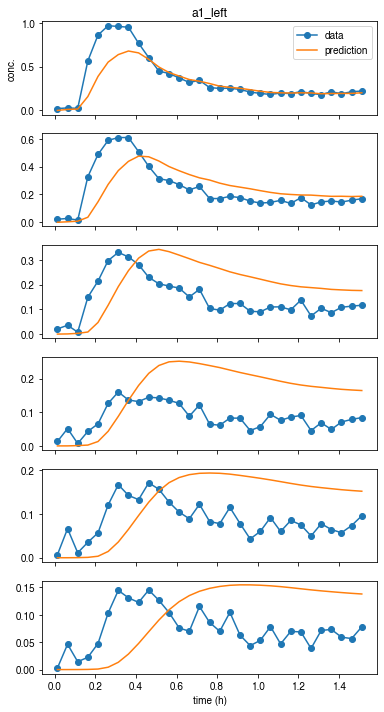

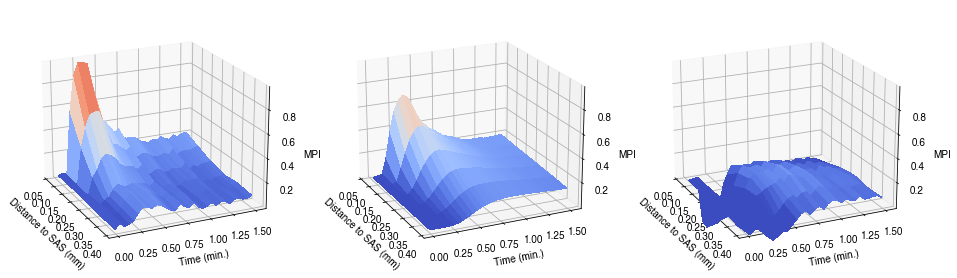

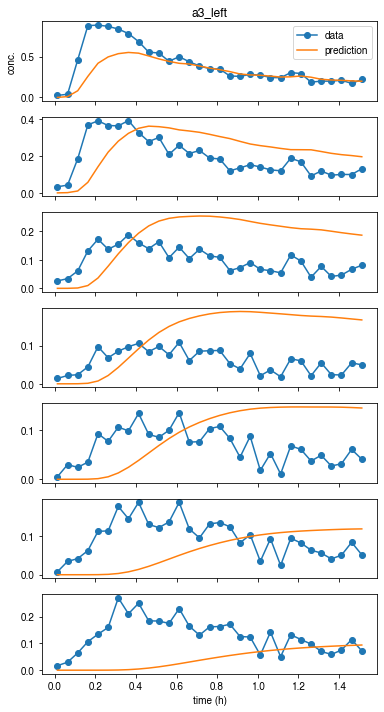

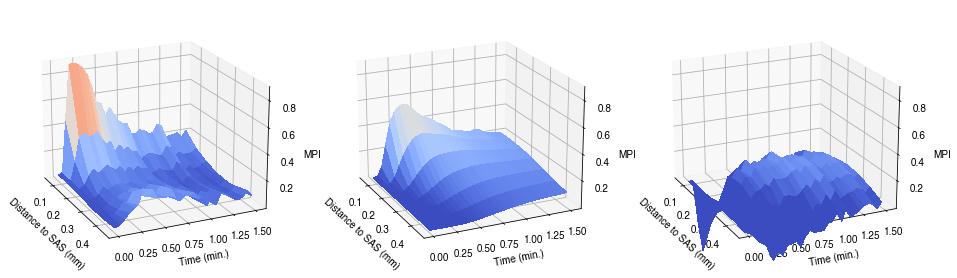

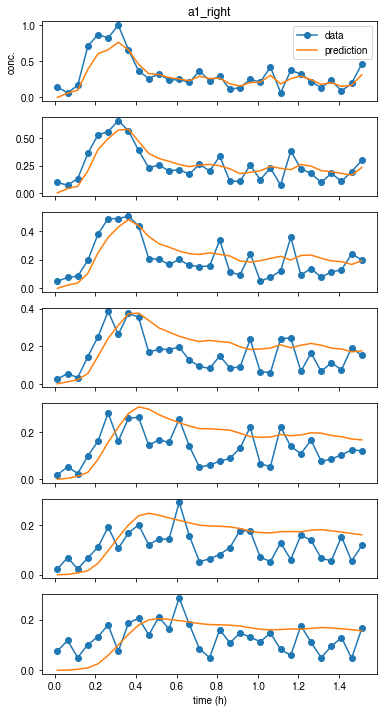

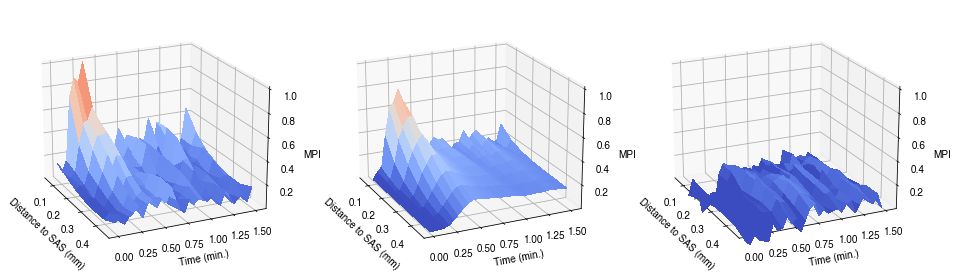

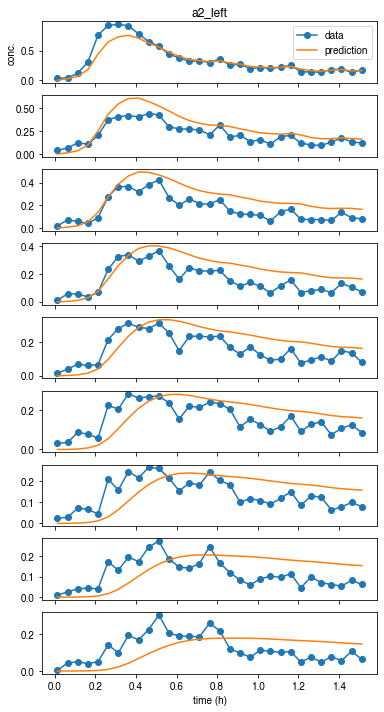

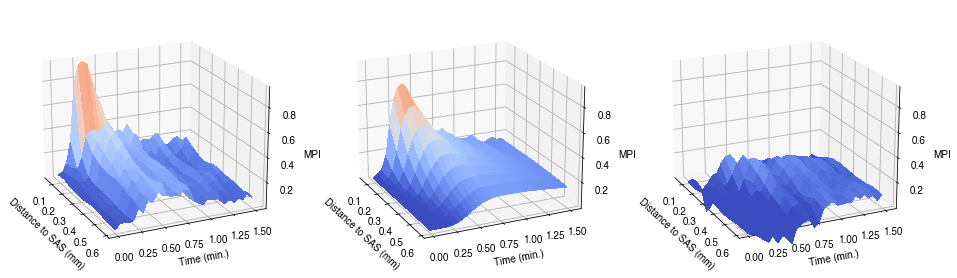

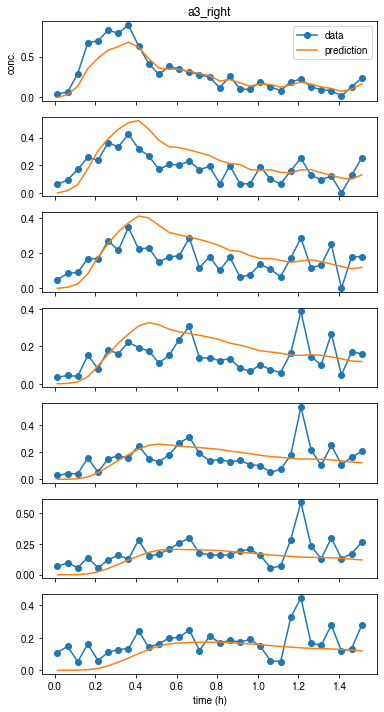

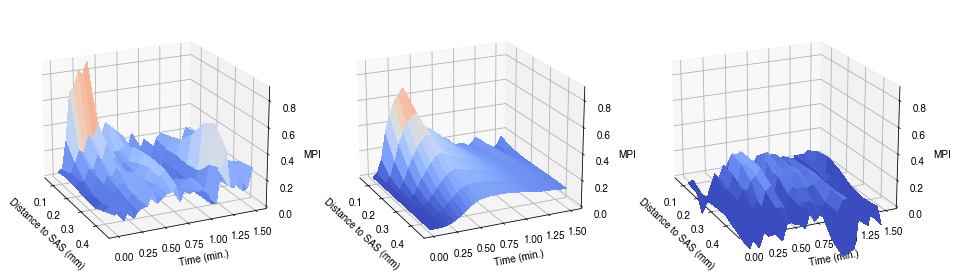

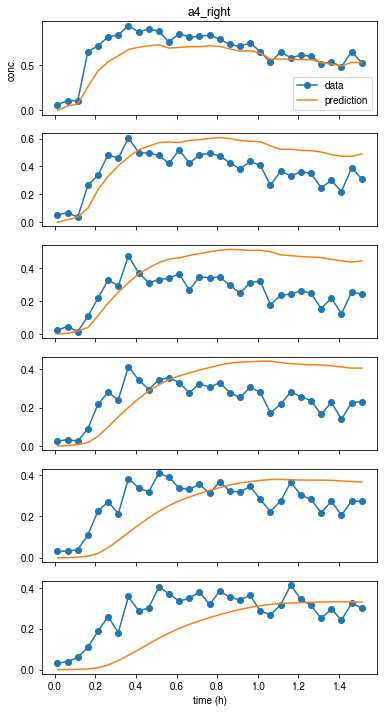

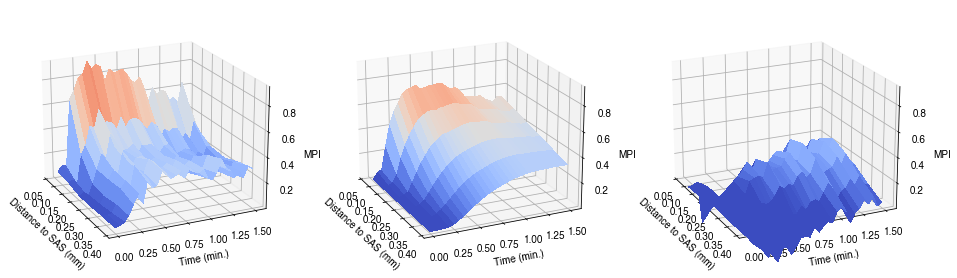

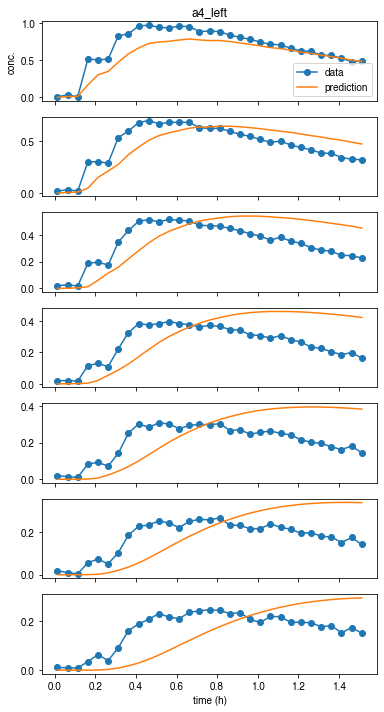

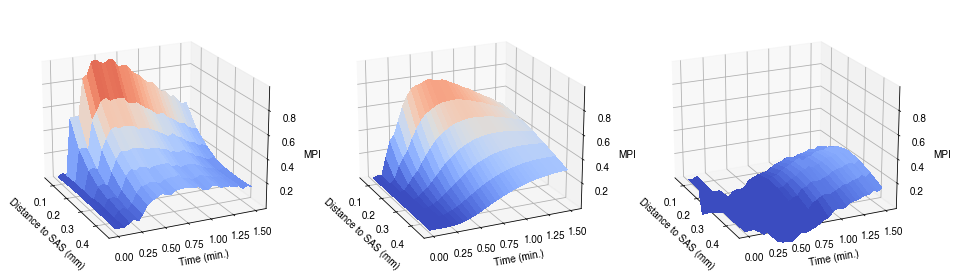

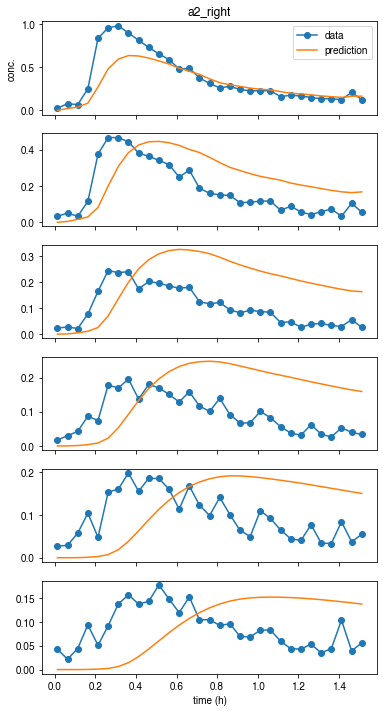

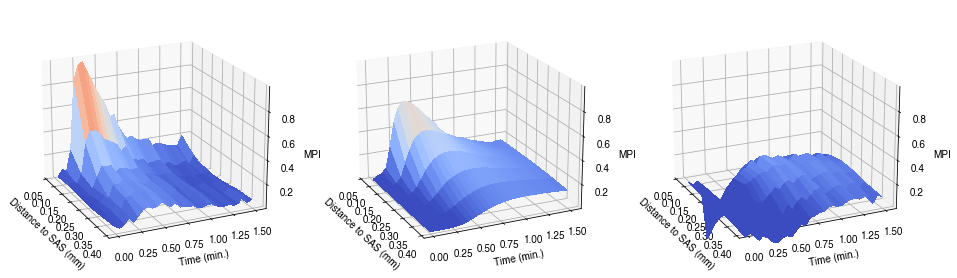

In [143]:
for ID, D in zip(resultsdf["ID"], resultsdf["D"]):
    cs.plot_compare_data_prediction(
        parseddatafolder + ID + '/',
        ID,
        D,
        4,
        f'{resultsfolder}/fitplots/{ID}.png'
    )
    